# 手写数字

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

import torchvision

import pytorch_lightning as pl

from data.mnist_dm import MNISTDataModule


## 加载数据集

60000
torch.Size([3, 28, 28]) 5
torch.Size([32, 3, 28, 28]) torch.Size([32])


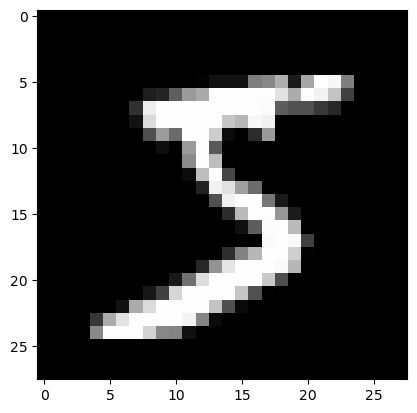

In [18]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from data.mnist_dm import CatImg

transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3801,)),  # 正则化，降低模型复杂度
    CatImg()  # 增加通道数 1->3
])

tr_set = MNIST('data', train=True, download=True, transform=transform)

print(len(tr_set))

img, label = tr_set[0]
print(img.shape, label)

plt.imshow(img[0], cmap='gray')

# 遍历一次取一批数据
tr_loader = DataLoader(tr_set, batch_size=32, shuffle=True)

imgs, labels = next(iter(tr_loader))
print(imgs.shape, labels.shape)


## 模型

In [19]:
from torchvision.ops import Permute
from functools import partial


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 5),  # B * 1 * 28 * 28 -> B * 16 * 24 * 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> B * 16 * 12 * 12
            nn.Conv2d(16, 24, 3),  # -> B * 24 * 10 * 10
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(24 * 10 * 10, 480),  # B * 2400 -> B * 480
            nn.ReLU(),
            nn.Linear(480, 10)
        )

    def forward(self, x):
        input_size = x.size(0)
        x = self.conv(x)
        x = x.view(input_size, -1)

        return self.fc(x)


from torchvision.models.swin_transformer import SwinTransformerBlockV2, PatchMergingV2, swin_v2_t, Swin_V2_T_Weights


class TransNet(nn.Module):
    def __init__(self):
        super(TransNet, self).__init__()

        self.embed_dim = 96

        norm_layer = partial(nn.LayerNorm, eps=1e-5)

        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, self.embed_dim, kernel_size=(4, 4), stride=(4, 4)),  # 3 * 28 * 28 -> 96 * 7 * 7
            Permute([0, 2, 3, 1]),  # B C H W -> B H W C
            norm_layer(self.embed_dim)  # 归一化
        )

        self.basic_block = nn.Sequential(  # 7 * 7 * 96 -> 7 * 7 * 96
            SwinTransformerBlockV2(
                dim=self.embed_dim,
                num_heads=3,
                shift_size=[0, 0],
                window_size=[8, 8],
            ),
            SwinTransformerBlockV2(
                dim=self.embed_dim,
                num_heads=3,
                shift_size=[4, 4],
                window_size=[8, 8],
            ),
        )

        self.patch_merge = PatchMergingV2(  # 7 * 7 * 96 -> 4 * 4 * 192
            dim=self.embed_dim,
            norm_layer=norm_layer
        )

        self.permute = Permute([0, 3, 1, 2])  # B H W C -> B C H W
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten(1)

        self.head = nn.Linear(192, 10)

    def forward(self, x):
        x = self.patch_embed(x)  # B * 7 * 7 * 96
        x = self.basic_block(x)  # B * 7 * 7 * 96
        x = self.patch_merge(x)  # B * 4 * 4 * 192

        x = self.permute(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.head(x)

        return x


model = TransNet()
print('model loaded')

output = model(imgs)
print(output.shape)


model loaded
torch.Size([32, 10])


## 系统

In [20]:
from pytorch_lightning import LightningModule
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchmetrics.classification import MulticlassAccuracy
from torchvision import models


class TransLitModule(LightningModule):
    def __init__(self, batch_size=32, lr=0.001):
        super(TransLitModule, self).__init__()
        self.save_hyperparameters()

        self.model = models.swin_v2_t()

        self.loss_fn = CrossEntropyLoss()

        self.acc = MulticlassAccuracy(num_classes=10)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.hparams.lr)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch

        preds = self(imgs)
        loss = self.loss_fn(preds, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch

        pred = self(imgs)
        loss = self.loss_fn(pred, labels)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch

        pred = self(imgs)
        loss = self.loss_fn(pred, labels)
        self.acc(pred, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.acc, on_step=False, on_epoch=True)
        return loss


mnist_dm = MNISTDataModule('data')
module = TransLitModule(256)
print('module loaded')

module loaded


In [21]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=3,
    mode='min',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

logger = TensorBoardLogger('logs', name='mnist')


In [22]:
from pytorch_lightning import Trainer
from pytorch_lightning.tuner import Tuner

trainer = Trainer(
    max_epochs=3,
    precision='16-mixed',
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    num_sanity_val_steps=0,
    # fast_dev_run=True
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
tuner = Tuner(trainer)

print(module.hparams)

tuner.lr_find(module, datamodule=mnist_dm)
tuner.scale_batch_size(module, datamodule=mnist_dm)

print(module.hparams)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

C:\tools\miniconda3\envs\ML\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
LR finder stopped early after 83 steps due to diverging loss.
Learning rate set to 4.786300923226383e-07
Restoring states from the checkpoint path at D:\OneDrive - stu.ahu.edu.cn\code\PYTHON\LeML\.lr_find_369d4961-7501-4954-86d0-759d1dcbde59.ckpt
Restored all states from the checkpoint at D:\OneDrive - stu.ahu.edu.cn\code\PYTHON\LeML\.lr_find_369d4961-7501-4954-86d0-759d1dcbde59.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` sto

"batch_size": 512
"lr":         4.786300923226383e-07


In [24]:
%load_ext tensorboard
%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [25]:

trainer.fit(module, datamodule=mnist_dm)

trainer.test(module, datamodule=mnist_dm)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | TransNet           | 28.4 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.446   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.10579527169466019
        test_loss            2.472641706466675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.472641706466675, 'test_acc': 0.10579527169466019}]